**Authors**: Carayon Chloé - Taillieu Victor

**Date**: 01/12/2020

---
# LAB2 Machine Learning: Bike Rental
---

## Introduction

In this second lab, we have to reuse our predictive model from the first lab, 
compare it to several regression models and improve it by doing feature engineering.  
We created a class implementing our linear regression model in **linreg.py** and we will use 
it for our model from scratch.


In [1]:
import sys
sys.path.append("../Lab1")
from linreg import LinearRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

## 1. Data understanding

Before building models, we have to understand our data. As explained in the lab instructions,
we have to build a predictive model to help bike rental companies in predicting the hourly demand on bikes.

### 1.1. Loading and exploring data

In [2]:
df = pd.read_csv("data/bike.csv")
df.head()

,season,yr,mnth,hr,holiday,workingday,weathersit,temp,hum,windspeed,dayOfWeek,days,demand
0,1,0,1,0,0,0,1,0.24,0.81,0.0,Sat,0,16
1,1,0,1,1,0,0,1,0.22,0.80,0.0,Sat,0,40
2,1,0,1,2,0,0,1,0.22,0.80,0.0,Sat,0,32
3,1,0,1,3,0,0,1,0.24,0.75,0.0,Sat,0,13
4,1,0,1,4,0,0,1,0.24,0.75,0.0,Sat,0,1


Our dataset is composed of 13 columns. During two years, data has been collected each hour:
the date (hour, day, month and year), the associated weather conditions (temperature, humidity and windspeed)
and the day particularity (holiday and working day).

Those variables have different types: the temperature, humidity and windspeed are numerical whereas season, year, month, hour are categorical. 
Some are also boolean such as holiday and workingday. Finally, dayOfWeek could be converted in categorical as it is string and can't be used like this.

Let's look at some plots to familiarize with those data.

### 1.2. Data Visualisation

####  1.2.1. Bike rental demand depending on the hour of the day 

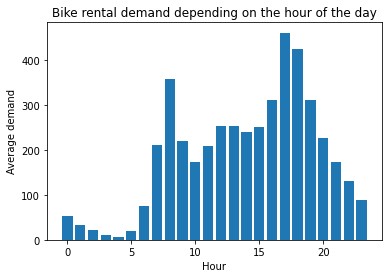

In [3]:
plt.bar(df.hr.unique(), df.groupby("hr").mean().demand)
plt.title("Bike rental demand depending on the hour of the day")
plt.xlabel("Hour")
plt.ylabel("Average demand")
plt.show()

This first graph shows the dispersion of rental bike demand across hours. 
Only few people rent bikes during the night and early in the morning. 
Most of the rents are done during the morning around 8 and in the afternoon around 17, else the rental
is correct but declined during the evening.

The hours where bikes are mostly rented, correspond to potential hours for workers to go and leave work. 
But it can also be linked to the day, the weather conditions and the season. When the weather is nice, people may rent a bike more easily. 

#### 1.2.2. Bike rental demand depending on the day of the week

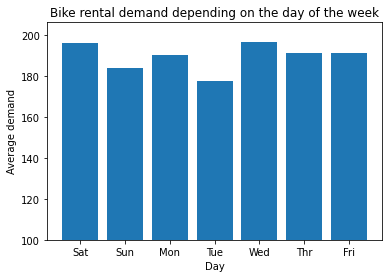

In [4]:
plt.bar(df.dayOfWeek.unique(), df.groupby("dayOfWeek").mean().demand)
plt.title("Bike rental demand depending on the day of the week")
plt.xlabel("Day")
plt.ylabel("Average demand")
plt.ylim(100)
plt.show()

We can see that there is not much difference in bikes demand between the different days of the week on average.

#### 1.2.3. Bike rental demand depending on working days and holidays

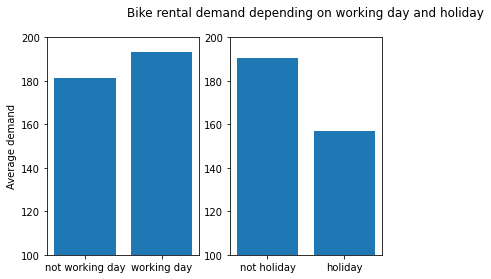

In [5]:
plt.subplot(121)
plt.bar(df.workingday.unique(), df.groupby("workingday").mean().demand)
plt.ylabel("Average demand")
plt.ylim(100, 200)
plt.xticks([0, 1], ['not working day', 'working day'])

plt.subplot(122)
plt.bar(df.holiday.unique(), df.groupby("holiday").mean().demand)
plt.ylim(100, 200)
plt.xticks([0, 1], ['not holiday', 'holiday'])

plt.title("Bike rental demand depending on working day and holiday\n")
plt.show()

Those two plots confirm what we have supposed above, it shows that more bikes are rented during working days than on weekend and holidays.  
We also notice that the demand difference is more pronounced for holiday/not holiday than for working day/not working day


#### 1.2.4. Bike rental demand depending on the season

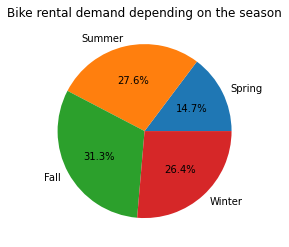

In [6]:
plt.pie(df.groupby("season").mean().demand, labels=["Spring", "Summer", "Fall", "Winter"], autopct="%1.1f%%")
plt.title("Bike rental demand depending on the season")
plt.show()

The majority of demands is in Fall, Summer and Winter.
A third of those demands is made in Fall, then there are many demands in Summer and Winter with respectively 3.7% and 4.9% of difference with Fall.
The rental bike decreases in Spring, only few people rent bike: around 14.7% of demand.   
We can ask ourselves if the bike rental demand is linked to the temperature.


#### 1.2.5. Bike rental demand depending on the temperature

Temperature data has been normalized which explains why values are between 0 and 1.

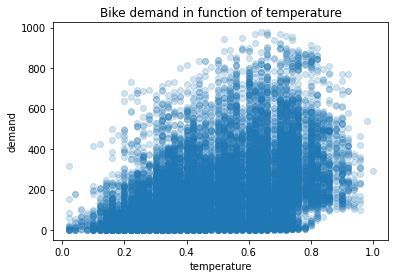

In [7]:
plt.scatter(df.temp, df.demand, alpha=0.2)
plt.title("Bike demand in function of temperature")
plt.xlabel("temperature")
plt.ylabel("demand")
plt.show()

The temperature clearly has a positive correlation with the demand. When the temperature increases, the demand globally increases.  
This variable will be useful in the linear model.

0.00    0.02
0.25    0.34
0.50    0.50
0.75    0.66
1.00    1.00
Name: temp, dtype: float64


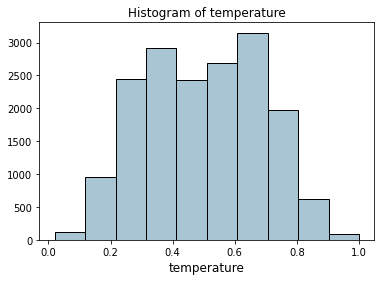

In [8]:
fig, ax = plt.subplots()
df['temp'].hist(bins=10, color='#A9C5D3', edgecolor='black', grid=False)
ax.set_title('Histogram of temperature', fontsize=12)
ax.set_xlabel('temperature', fontsize=12)

print(df.temp.quantile([0, 0.25, 0.5, 0.75, 1]))

For the temperature, most of the values are between 0.34 and 0.66. It has the shape of a normal distribution.

### 1.3. Data preprocessing

This first approach on our dataset made us understand that many variables can influence bike rental demand.

#### 1.3.1. Handling missing values 

Let's quickly check if there are missing values:

In [9]:
print("Number of missing values:",df.isnull().sum().sum())

Number of missing values: 0


There is no missing value in this dataset.

#### 1.3.2. Handling string data

There is one variable which can't be properly used for our linear model: dayOfWeek.   
In order to use it, we have to convert those days in numerical values. We obtain the following result:

In [10]:
# ['Sat' 'Sun' 'Mon' 'Tue' 'Wed' 'Thr' 'Fri'] -> [2 3 1 5 6 4 0]
df["dayOfWeek"] = df["dayOfWeek"].astype("category").cat.codes
df.describe()

,season,yr,mnth,hr,holiday,workingday,weathersit,temp,hum,windspeed,dayOfWeek,days,demand
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,0.682721,1.425283,0.496987,0.627229,0.190098,2.992577,361.562576,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,0.465431,0.639357,0.192556,0.192930,0.122340,1.997928,209.042828,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,0.000000,1.000000,0.340000,0.480000,0.104500,1.000000,181.000000,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,1.000000,1.000000,0.500000,0.630000,0.194000,3.000000,362.000000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,1.000000,2.000000,0.660000,0.780000,0.253700,5.000000,543.000000,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,1.000000,4.000000,1.000000,1.000000,0.850700,6.000000,724.000000,977.000000


## 2. Building models

We use the class LinearRegression in **linreg.py ** created in the previous lab to build a model using gradient descent. 

### 2.1. Train and test sets

As we have used train and test through the first lab, we decided to add the splitting operation in our **LinearRegression** class.

To do so, we have corrected our `preprocessingData` function by adding from Scikit-Learn library, the train_test_split function:  
`X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)`

### 2.2. Gradient descent

With $\alpha = 0.01$, we obtain the following results for our `train` and `test` sets:

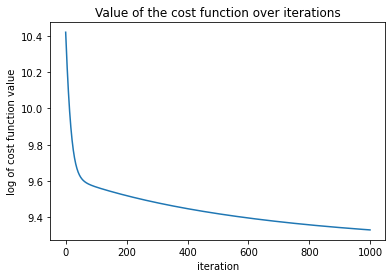

Gradient descent coefficients:
[[ 27.43389817]
 [ 43.83444628]
 [ 64.36551259]
 [ 13.60325224]
 [137.16673552]
 [ -4.87068748]
 [  6.52130698]
 [-33.73262516]
 [106.7804526 ]
 [-67.68198006]
 [ 24.90593609]
 [  0.78937668]
 [ 38.94099136]]
MAE: 113.32747297188442
R2:
Train: 0.32083882807538466
Test: 0.3114911256467666


In [11]:
model_grad1 = LinearRegression(df)
model_grad1.gradientDescent(alpha=0.01)
model_grad1.plotCost()
print("Gradient descent coefficients:")
print(model_grad1.w)

print("MAE:", model_grad1.MAE)
print("R2:")
print("Train:", model_grad1.R2)
print("Test:", model_grad1.test_R2)

The convergence is very slow and the log of the cost function value is around 9.4.
Looking at $R^2$ and $MAE$, we clearly see that our model does not fit the data very well. In fact, the quality of the 
fitting is only 32%. 

In order to obtain a better model, we can improve our **hyperparameters** by increasing $\alpha$ and decreasing the $threshold$.

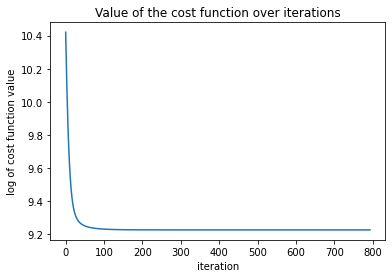

Gradient descent coefficients:
[[  15.25614432]
 [  62.16363578]
 [  70.1350214 ]
 [ -10.19451843]
 [ 176.85420204]
 [ -27.4104932 ]
 [   4.30315651]
 [ -11.33107788]
 [ 273.63532282]
 [-198.095751  ]
 [  20.9882641 ]
 [  -3.36688933]
 [  24.98548201]]
MAE: 106.66332152370752
R2:
Train: 0.38761758431685356
Test: 0.3855197492585182


In [12]:
model_grad2 = LinearRegression(df)
model_grad2.gradientDescent(alpha=0.5, threshold=1e-4)
model_grad2.plotCost()
print("Gradient descent coefficients:")
print(model_grad2.w)

print("MAE:", model_grad2.MAE)
print("R2:")
print("Train:", model_grad2.R2)
print("Test:", model_grad2.test_R2)

The convergence is better and the log of the cost function is around 9.2.  
But $R^2$ and $MAE$ are still very bad: the quality of the fitting is only around 38%.

### 2.3. Normal equation

We can build a new model with the normal equation which should give better results.

In [13]:
model_norm = LinearRegression(df)
model_norm.normalEquation()
print("Normal equation coefficients:")
print(model_norm.w)

print("MAE:", model_norm.MAE)
print("R2:")
print("Train:", model_norm.R2)
print("Test:", model_norm.test_R2)

Normal equation coefficients:
[[  16.82540449]
 [  62.01144869]
 [ 116.58965098]
 [  32.48776091]
 [ 176.96206809]
 [ -27.50480882]
 [   4.30596978]
 [ -11.2490898 ]
 [ 273.51027645]
 [-198.28934502]
 [  20.67036957]
 [  -3.39974329]
 [ -67.35622144]]
MAE: 106.66142249364468
R2:
Train: 0.3876553087897192
Test: 0.38567137931379636


The results for $R^2$ and $MAE$ are slightly better from the ones we obtain with our linear model.
The difference between $MAE$ is infinitesimal, around 1e-3.  
As we can see, the $R^2$ value for the test set is a little bit smaller than for the train set (0.385 < 0.387).
This is nice because it means that we do not have a model that **overfits** the data.

### 2.4. Scikit-Learn

Using Scikit-Learn, we can once again build a linear model.

In [14]:
print("Scikit-learn")
X = df.iloc[:, :-1]
y = df.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
s = np.insert(reg.coef_.T, 0, reg.intercept_)
print(np.vstack(s))

print("MAE:", mean_absolute_error(y_train, reg.predict(X_train)))
print("Train:", r2_score(y_train, reg.predict(X_train)))
print("Test:", r2_score(y_test, reg.predict(X_test)))

Scikit-learn
[[  16.82540449]
 [  62.01144869]
 [ 116.58965098]
 [  32.48776091]
 [ 176.96206809]
 [ -27.50480882]
 [   4.30596978]
 [ -11.2490898 ]
 [ 273.51027645]
 [-198.28934502]
 [  20.67036957]
 [  -3.39974329]
 [ -67.35622144]]
MAE: 106.6614224936571
Train: 0.38765530878971943
Test: 0.38567137931378104


We obtain values for $R^2$ and $MAE$ very close to the previous models.  

But for those three models, $R^2$ and $MAE$ are very bad respectively around 38% and 106. 
If we want to properly fit our data, we need to improve our models.  
First, let's take a look at some data to see possible future improvements.

## 3. Insights

To clearly see the accuracy of our models, we can look at the difference between predicted and actual label values.

We create a new dataframe with our predicted values.

In [15]:
df_pred = df.copy()
df_pred["predicted"] = model_norm.predict(df.iloc[:, :-1])

### 3.1. Grouping data by hour

Let's compare the mean and standard deviation difference between real demand and our predicted values through time.

In [16]:
df_pred.groupby("hr").agg(["mean", "std"])[["demand", "predicted"]]

demand               predicted           
          mean         std        mean        std
hr                                               
0    53.898072   42.307910   79.939755  78.290049
1    33.375691   33.538727   82.622850  77.216068
2    22.869930   26.578642   87.040627  75.861173
3    11.727403   13.239190   92.407156  73.587678
4     6.352941    4.143818   96.692316  72.654095
5    19.889819   13.200765   99.691743  73.567485
6    76.044138   55.084348  105.382607  74.370436
7   212.064649  161.441936  117.418399  77.428100
8   359.011004  235.189285  135.500399  82.069483
9   219.309491   93.703458  157.708207  84.748934
10  173.668501  102.205413  181.450376  88.116591
11  208.143054  127.495536  204.318109  89.750415
12  253.315934  145.081134  223.872565  91.229614
13  253.661180  148.107657  240.901325  91.643298
14  240.949246  147.271574  254.678215  92.677621
15  251.233196  144.632541  264.413343  93.197498
16  311.983562  148.682618  270.408733  93.361278
17  461.452055  232.656611  271.567427  93.440580
18  425.510989  224.639304  270.979753  91.054272
19  311.523352  161.050359  266.449182  88.245691
20  226.030220  119.670164  263.686860  85.934677
21  172.314560   89.788893  261.375872  83.308579
22  131.335165   69.937782  261.590253  81.767488
23   87.831044   50.846889  262.258506  79.709445

We clearly see that for the predicted values, the mean and standard increase drastically through time and decrease a little bit around 19.  
Whereas for the demand, values increase and decrease over time and it does not seem to be any linear relationship between data and time.  
We can suppose that as there is only one column for all the hours, our model interpretes each hour number as a weight even if it is not the case. 

In order to improve the model, we could split them into different columns.

### 3.2. Grouping data by season

Let's compare the mean and standard deviation difference between real demand and our predicted values across seasons.

In [17]:
df_pred.groupby("season").agg(["mean", "std"])[["demand", "predicted"]]

demand               predicted            
              mean         std        mean         std
season                                                
1       111.114569  119.224010  114.320369   98.687537
2       208.344069  188.362473  193.064142  107.683386
3       236.016237  197.711630  257.748707  101.115423
4       198.868856  182.967972  191.696585   95.805637

The four seasons correspond to the following numbers: spring = 1, summer = 2, fall = 3, and winter = 4.  
Our predicted values try to fit the demand, but we clearly see that we have some huge differences: for fall and winter, 
the predicted standard deviation is lower of 96 and 87 from the demand one.  
The predicted mean of spring is the only one which is close to the demand and which corresponds to number 1.

So we may suppose that once again, the model interprets the numerus of each season as a weight which
explains why the mean of the predicted season increases with the season number associated.
We could split them into different columns, in order to improve the model.

### 3.3. Grouping data by holiday

Let's compare the mean and standard deviation difference between real demand and our predicted values depending on holiday.

In [18]:
df_pred.groupby("holiday").agg(["mean", "std"])[["demand", "predicted"]]

demand               predicted            
              mean         std        mean         std
holiday                                               
0        190.42858  181.981435  191.257503  113.060898
1        156.87000  156.757478  156.059113  108.243821

The mean for the predicted values for both holiday and not holiday are very close to the real values, 
but we clearly see that the standard deviation of the predicted ones did not reached at all the demand.
We can suppose that improving other features may have an impact on the holiday.

### 3.4. Grouping data by weathersit

Let's compare the mean and standard deviation difference between our demand and our predicted values depending on the weathersit.

In [19]:
df_pred.groupby("weathersit").agg(["mean", "std"])[["demand", "predicted"]]

demand               predicted            
                  mean         std        mean         std
weathersit                                                
1           204.869272  189.487773  208.150525  113.629854
2           175.165493  165.431589  163.507350  103.116244
3           111.579281  133.781045  132.195743  102.024324
4            74.333333   77.925178   26.612854   77.434211

For the weather site, we have: clear = 1, cloudy = 2, light rain = 3 and heavy rain = 4.
Some predicted values are close to the demand, such as the standard deviation of the rain or the mean of the clear weather. 
But, most of the time, standard deviation of the predicted values are under the standard deviation of the demand.

So we may suppose that once again, the model interpretes the numerus of each weathersit as a weight.
We could split them into different columns, in order to improve the model.

## 4. Feature engineering

We can improve our model, by doing feature engineering.  
We copy the previous dataframe and create a new one, to perform feature engineering.

### 4.1. Missing values 

As we have seen in the data processing part, there is no missing values in our dataset. 

### 4.2. Drop features 

Thanks to the data visualisation part, we were able to catch the importance of the different features on the label.  
We drop the less significant predictor features below:

* **days**  
Days column was pointless as it was working as a counter for days. It was irrelevant for the demand.

* **dayOfWeek**  
The difference demand between days of the week is thin. So, we can drop the column as it does not 
influence the demand as much as other features such as the season.

* **workingday**   
Looking at the plot of working day, we noticed that the demand difference was less pronounced compare to the
one of the holiday. 

In [20]:
df_cleaned = df.copy()
df_cleaned.drop("days", axis=1, inplace=True)
df_cleaned.drop("dayOfWeek", axis=1, inplace=True)
df_cleaned.drop("workingday", axis=1, inplace=True)

### 4.3. Categorical features 

As we have seen in the insight part, some columns represent categories of data such as season or hour and we can 
split them in order to improve our model.  
Indeed, keeping them as they are introduces a relation of order (for example spring < summer < fall < winter) that is not correct here.

#### 4.3.1. Dummy features 

We didn't have to dummy binary features such as holiday, we only dummy features with more than 2 categories: 

* **hours column**  
We can split the hours column in 24 subcolumns:

In [21]:
hours = pd.get_dummies(df_cleaned["hr"])
index = df_cleaned.columns.get_loc("hr")
df_cleaned.drop("hr", axis=1, inplace=True)

for i in range(hours.shape[1]):
    df_cleaned.insert(index + i, "hr.{}".format(i), hours[i])

* **months column**  
We can split the months column in 12 subcolumns:

In [22]:
months = pd.get_dummies(df_cleaned["mnth"])
index = df_cleaned.columns.get_loc("mnth")
df_cleaned.drop("mnth", axis=1, inplace=True)
list_month = ["jan", "feb", "mar", "apr"," may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

for i in range(months.shape[1]):
    df_cleaned.insert(index + i, list_month[i], months[i + 1])

* **season column**  
We can split the season column in 4 subcolumns:

In [23]:
seasons = pd.get_dummies(df_cleaned["season"])
index = df_cleaned.columns.get_loc("season")
df_cleaned.drop("season", axis=1, inplace=True)
df_cleaned.insert(index, "spring", seasons[1])
df_cleaned.insert(index + 1, "summer", seasons[2])
df_cleaned.insert(index + 2, "fall", seasons[3])
df_cleaned.insert(index + 3, "winter", seasons[4])

* **weathersit column**  
We can split the weathersit column in 4 subcolumns:

In [24]:
weathers = pd.get_dummies(df_cleaned["weathersit"])
index = df_cleaned.columns.get_loc("weathersit")
df_cleaned.drop("weathersit", axis=1, inplace=True)
list_weathers = ["clear", "cloudy", "light.rain", "heavy.rain"]

for i in range(weathers.shape[1]):
    df_cleaned.insert(index + i, list_weathers[i], weathers[i + 1])


### 4.4. Numerical/continuous features 

For numerical features, we firstly wanted to split each feature column in 3 subcolumns depending on the quantiles.
But, after observation of this technic on humidity, windspeed and temperature, we noticed that it gave us a loss
of information and had badly influenced $R^2$.


### 4.5. Model with the modified features

Doing feature engineering, we obtain the following columns:

In [25]:
df_cleaned.columns

Index(['spring', 'summer', 'fall', 'winter', 'yr', 'jan', 'feb', 'mar', 'apr',
       ' may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'hr.0', 'hr.1',
       'hr.2', 'hr.3', 'hr.4', 'hr.5', 'hr.6', 'hr.7', 'hr.8', 'hr.9', 'hr.10',
       'hr.11', 'hr.12', 'hr.13', 'hr.14', 'hr.15', 'hr.16', 'hr.17', 'hr.18',
       'hr.19', 'hr.20', 'hr.21', 'hr.22', 'hr.23', 'holiday', 'clear',
       'cloudy', 'light.rain', 'heavy.rain', 'temp', 'hum', 'windspeed',
       'demand'],
      dtype='object')

We can now build a new model on df_cleaned dataframe, using our gradient descent function:

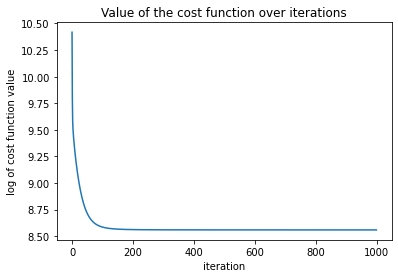

MAE:
75.61891123531998
R2:
Train: 0.6860157429793772
Test: 0.6801797492699438


In [26]:
model_grad2 = LinearRegression(df_cleaned)
model_grad2.gradientDescent(alpha=0.5, threshold=1e-4)
model_grad2.plotCost()

print("MAE:")
print(model_grad2.MAE)

print("R2:")
print("Train:", model_grad2.R2)
print("Test:", model_grad2.test_R2)

Our $MAE$ and $R^2$ are twice better thanks to feature engineering.  
However the $R^2$ is still not very good (0.68), that is why we are going to test other models in the next part.

We can compare the real demand to the predicted one.

In [27]:
df_pred2 = df_cleaned.copy()
df_pred2["predicted"] = model_grad2.predict(df_cleaned.iloc[:, :-1])

print("- Prediction for hour 1 with feature engineering")
print(df_pred2[df_pred2['hr.1'] == 1].agg(["mean", "std"])[["demand", "predicted"]])

print("\n- Prediction for fall with feature engineering")
print(df_pred2[df_pred2['fall'] == 1].agg(["mean", "std"])[["demand", "predicted"]])

- Prediction for hour 1 with feature engineering
         demand  predicted
mean  33.375691  34.096046
std   33.538727  73.719459

- Prediction for fall with feature engineering
          demand   predicted
mean  236.016237  237.189056
std   197.711630  142.512668


Compared to the previous prediction, we are closer to the demand, but we still have important differences as
we can see with standard deviation of fall and hour 1.  
In order to better fit our data, we can try other models.

## 5. Other models

Using Scikit-Learn library, we can build GradientBoostingRegressor and RandomForest models to better fit our data.

### 5.1. Gradient Boosting Regressor

The Gradient Boosting Regressor is different from the linear regression even if it uses gradient descent to
minimize the lost.  
It consists of combining multiple models into a single one: it adds new models to the huge one, which gives 
a stronger predictor.
In fact, it uses the concept of decision trees as each node represents an attribute and each leaf node represents a label.

In [28]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)

print('Mean Absolute Error:', mean_absolute_error(y_train, gbr.predict(X_train)))
print("R2:")
print("Train:", r2_score(y_train, gbr.predict(X_train)))
print("Test:", r2_score(y_test, gbr.predict(X_test)))

c:\python\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Mean Absolute Error: 45.94885124235284
R2:
Train: 0.8656024842527666
Test: 0.8685019033559096


Using Gradient Boosting Regressor, we obtain 0.86 for $R^2$ and 45.9 for $MAE$. It is much better than the linear regression.  

Let's take a look at the predictions:

In [29]:
df_pred3 = df.copy()
df_pred3["predicted"] = gbr.predict(scaler.transform(df.iloc[:, :-1]))

print("- Prediction for hour 1 with gradient boosting regressor")
print(df_pred3[df_pred3['hr'] == 1].agg(["mean", "std"])[["demand", "predicted"]])

print("\n- Prediction for fall with gradient boosting regressor")
print(df_pred3[df_pred3['season'] == 3].agg(["mean", "std"])[["demand", "predicted"]])

- Prediction for hour 1 with gradient boosting regressor
         demand  predicted
mean  33.375691  32.524649
std   33.538727  19.317482

- Prediction for fall with gradient boosting regressor
          demand   predicted
mean  236.016237  237.341575
std   197.711630  166.213355


The predicted results are closer to the demand, but we still see some aberation such as the standard deviation
of the predicted fall and hour 1. As we have $MAE$ of 45.9, we still have important difference.  
So an $R^2$ value of 0.86 is still not sufficient to correctly fit our data.

### 5.2. Random forest 

Random forest is made of multiple decision trees, each of them produces its own prediction and the Random forest 
combines their predictions to produce a more accurate prediction. 


In [30]:
regressor = RandomForestRegressor(n_estimators=10, random_state=42)
regressor.fit(X_train, y_train)

print('Mean Absolute Error:', mean_absolute_error(y_train, regressor.predict(X_train)))
print("R2:")
print("Train:", r2_score(y_train, regressor.predict(X_train)))
print("Test:", r2_score(y_test, regressor.predict(X_test)))

<ipython-input-30-1cb661d5bce2>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


Mean Absolute Error: 10.628900237358843
R2:
Train: 0.9892134371645537
Test: 0.941373517700752


Using Random forest, we obtain a $R^2$ value of 0.98 for the train set and 0.94 for the test set.
It is much better than the linear regression and gradient boosting regressor.  
Moreover, we only have a $MAE$ of 10. 

Let's take a look at the predictions:

In [31]:
df_pred4 = df.copy()
df_pred4["predicted"] = regressor.predict(scaler.transform(df.iloc[:, :-1]))

print("- Prediction for hour 1 with random forest")
print(df_pred4[df_pred4['hr'] == 1].agg(["mean", "std"])[["demand", "predicted"]])

print("\n- Prediction for fall with random forest")
print(df_pred4[df_pred4['season'] == 3].agg(["mean", "std"])[["demand", "predicted"]])

- Prediction for hour 1 with random forest
         demand  predicted
mean  33.375691  33.656630
std   33.538727  32.033695

- Prediction for fall with random forest
          demand   predicted
mean  236.016237  236.825378
std   197.711630  195.036559


Our predictions are similar to the demand as we have a small $MAE$ and an important $R^2$.
So now, we can predict the demand of bike rental depending on several parameters. 

## Conclusion

This second lab gave us the opportunity to manipulate huge amount of data, perform feature engineering and build several models.  
Thanks to this second approach on linear regression and the opening on other models, we clearly see that to find the
correct model, we need to assimilate the data and project the utility of the different features on the label.    
With the last part on other models, we learnt that seeing linear pattern between some of our features and our label 
and doing many feature engineering does not ensure that a linear model will fit our data and be the most appropriate model.  
We have to try several models to find the best one which fits our data.